In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import odeint

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# These are run control parameters
""" Fliq is the QLL (shape: nx)
    Ntot is the the combined values of the ice layers (Nice), combined with the QLL layer (Nliq or Fliq or NQLL variously referred to as)
        Ntot is shaped (2, nx)
"""

noisy_init = False
noise_std_dev = 0.01

# Flag for explicit updating Fliq(Ntot) every step 
updatingFliq = True
# Set up a maximum number of iterations or layers
uselayers = False

if uselayers:
    layermax_0D = 4
    layermax_1D = 1000
    layermax_2D = 2 #temporary initial test
else:
    countermax_0D = 100
    countermax_1D = 15000
    countermax_2D = countermax_0D*15#temporary initial test

In [4]:
# File loading variables
lastfile = 'NeshData/continuum_model6 28-5-2016[1][1].npz'; Load_old_file = False
nextfile = 'NeshData/continuum_model6 28-5-2016[1][1].npz'; Save_new_file = False
trajfile = 'NeshData/continuum_model6 28-5-2016[1][1].traj.npz'; trajflag = False
traj0file= 'NeshData/continuum_model6 28-5-2016[1][1].traj0.npz'; traj0flag = False

In [5]:
#Setting up the system
# Number of iterations to calculate Nliq from Ntot (Increased niter means more iterative calculation: converges on greater accuracy at cost of time)
niter = 1

# Loading/initializing state
if Load_old_file:  #load an old system
    print("loading", lastfile)
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    nx = len(x)
    deltaX = x[1]-x[0]
else:
    #new system
    nx = 500 # Number of points in simulation box
    xmax = 50 # range of x
    x = np.linspace(0, xmax, nx)
    
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K
    Nstar = .9/(2*np.pi)
    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.ones(nx)

    if noisy_init:
        # Initialize with noise
        noise = np.random.normal(0,noise_std_dev,nx)
        Nice += noise

    
    Fliq = ds.getNliq_array(Nice,Nstar,Nbar,niter)

# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

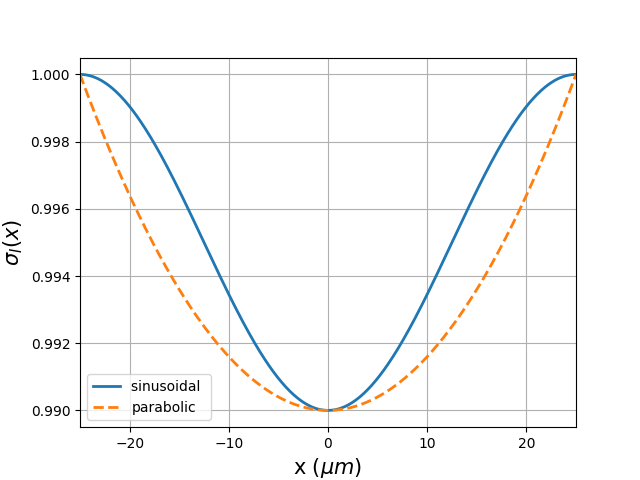

In [6]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 #-0.10 # Must be bigger than sigma0 to get growth, less than 0 for ablation
center_reduction = 1 #0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep_sinusoid = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='sinusoid') 
sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
sigmastepstyle = 'parabolic'
if sigmastepstyle=='sinusoid':
    sigmastep = sigmastep_sinusoid
elif sigmastepstyle=='parabolic':
    sigmastep = sigmastep_parabolic
else:
    print('bad choice')

# Graph sigma(x)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
         x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [7]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltaT_max (Diffusion time)', dtmax)
print('deltaT =', deltaT)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.20060160400962
deltaT = 1.0040120320801924
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.10020040080160321
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 1 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


0-D Modeled growth rate, um/s 0.8926552425182057
0-D Modeled growth rate, ml/us 0.0029755174750606857
0-D Modeled alpha 0.09108726964471486


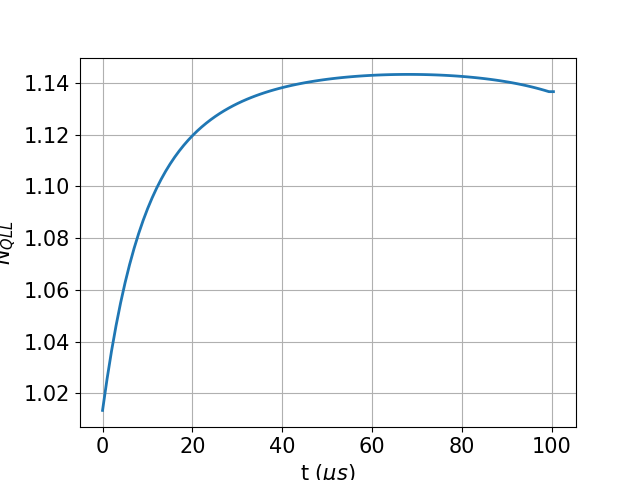

In [8]:
# This is the 0-d run
# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmastepmax, sigma0, deprate])

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,niter))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast

    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)

    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    # See whether to break
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_0D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_0D:
                print('breaking because reached max number of layers ablated')
                break 
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)
# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)


In [9]:
#Parameters for 1-D run 
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # dimensionless
print(D) # D is in micrometers^2/microsecond
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('Nss predicted')
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

25.0
0.01
0.16333333333333333
0.2
0.0002
Nss predicted
sinusoid: 16.71397312685169
paraboloic: 14.38071585819601


In [10]:
# This is the 1-d run
#Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx = params #original params
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([niter,nx])

# Initial conditions for ODE solver
y0 = np.array([Fliq,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True
counter = 0
lastlayer = 0
lastdiff = 0

while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(float_params,int_params,sigmastep),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT

    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
        
    # Test whether we're finished
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_1D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_1D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

0 0 2.9542125302928213e-05 2.9542125302928213e-05
157 1 0.48040859867406827 0.48037905654876534
314 2 0.765509067234674 0.2851004685606058
472 3 0.835418353362253 0.06990928612757896
629 4 0.8703491264693417 0.0349307731070887
787 5 0.8945973539706706 0.024248227501328934
944 6 0.915721493231505 0.02112413926083434
1102 7 0.9391056615292017 0.02338416829769674
1260 8 0.9690335750909593 0.029927913561757613
1417 9 1.003335327715515 0.034301752624555704
1575 10 1.5283881866729256 0.5250528589574106
1732 11 1.7743145487328302 0.2459263620599046
1890 12 1.8387784182258358 0.06446386949300553
2048 13 1.8721060914479093 0.03332767322207353
2206 14 1.8958234382456496 0.02371734679774029
2363 15 1.9166399851380316 0.020816546892381993
2521 16 1.9397601273135265 0.023120142175494962
2679 17 1.9695696464759678 0.029809519162441234
2837 18 2.003047740993292 0.03347809451732431
2995 19 2.5188921294546773 0.5158443884613853
3153 20 2.7680145603358177 0.2491224308811404
3311 21 2.8360734804380634 0.

Height of Ice 0
1-D growth, corner 93.08691627594838
1-D growth, center 84.2669874515403
1-D Modeled growth rate, corner, um/s 1.8542988191696872
1-D Modeled growth rate, corner, ml/us 0.0061809960638989575
1-D Modeled growth rate, center, um/s 1.6786051313932202
1-D Modeled alpha, corner 0.18927436791109892
1-D Modeled alpha, center 0.17301639489782392
Difference, % -8.589632707642314
0-D Modeled growth rate, um/s 0.8926552425182057
0-D Modeled growth rate, ml/us 0.0029755174750606857
0-D Modeled alpha 0.09108726964471486
Growth ratio 1D (corner)/0D 2.077284410427768
Growth ratio 1D (center)/0D 1.8804629732054534
Contribution of diffusion 88.04629732054534 %
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904
Time taken: 0 min 0.0 secs


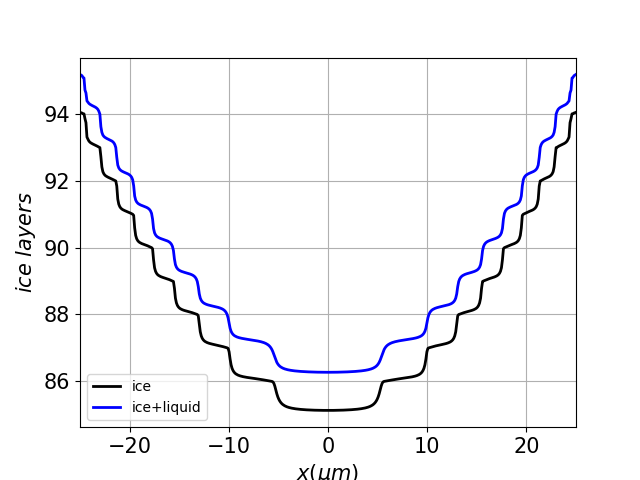

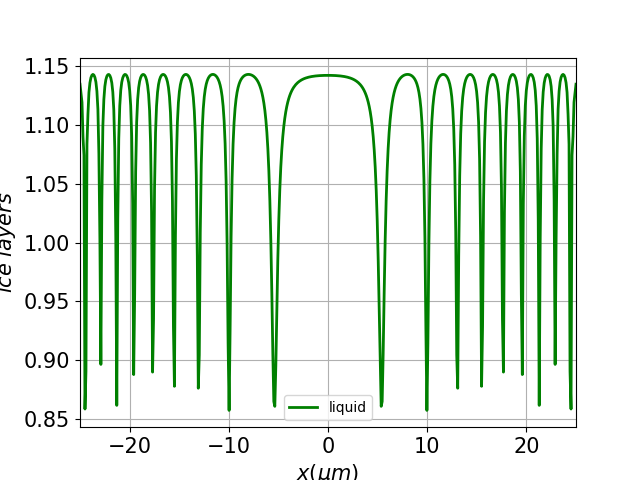

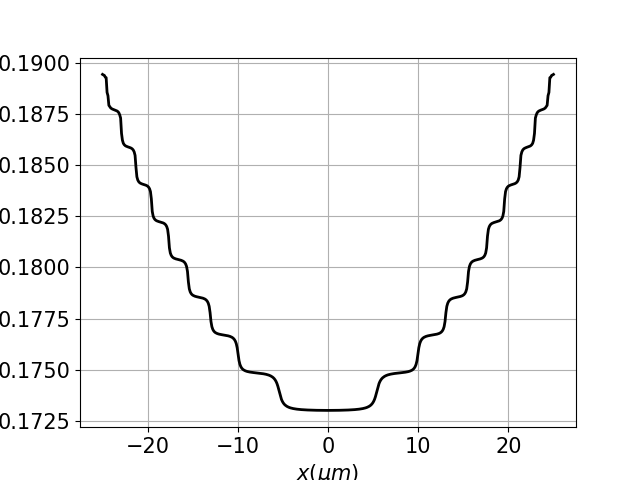

In [11]:
# Growth statistics
sec1 = time.time()

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
print( "0-D Modeled alpha", alpha_0d)
print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

# Timing statistics
sec2 = time.time()
print("Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs")

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

In [12]:
#Setting up the 2D system

nx = 500 # Number of points in simulation box
xmax = 50 # range of x
x = np.linspace(0, xmax, nx)

ny = nx
ymax = xmax
y = np.linspace(0, ymax, ny)

deltaX = x[1]-x[0]
deltaY = y[1]-y[0]

Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
# Initialize as a pre-equilibrated layer of liquid over ice

Nice = np.ones((nx,ny))

if noisy_init:
    # Initialize with noise
    noise = np.random.normal(0,noise_std_dev,(nx,ny))
    Nice += noise


Fliq = ds.getNliq_2d_array(Nice,Nstar,Nbar,niter)

# Lay out the system
Ntot = Fliq + Nice
# nmid = int(nx/2)
# nquart = int(nx/4)
# xmid = max(x)/2
# xmax = x[nx-1]
Nice_start = Nice[0]

#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

In [13]:
# This is the 2-d run

# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([niter,nx,ny])

# Initial conditions for ODE solver
y0 = np.array([Fliq,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0,0]
Nice0 = Nice[0,0]
Ntot0_start = Ntot[0,0]
Ntot0 = Ntot[0,0]
updatingFliq = True
counter = 0
lastlayer = 0
lastdiff = 0
while True:
    # Integrate up to next time step
    y = odeint(ds.f2d, np.reshape(ylast,np.prod(np.shape(ylast))), tinterval, args=(float_params,int_params,sigmastep),rtol=1e-12)
    # Update the state                  #NOTE: prod(shape(ylast)) is like (2*nx*ny) #unused--np.prod(np.shape(ylast))
    ylast = np.reshape(y[1],(2,nx,ny))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq_2d_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq

    Nice0 = Nice[0,0]
    Ntot0 = Ntot[0,0]
    ttot += deltaT

    # Stuff into keeper arrays if requested -- needed for making graphics
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = np.min(Nice)
        maxpoint = np.max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
        
    # Test whether we're finished
    if uselayers:
        print("appx progress:" , ((layer/layermax_2D)*100, "%"))
        if sigmastepmax > 0:
            if layer > layermax_2D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_2D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_2D-1:
            print('breaking because reached max number of iterations')
            break

0 0 0.004494685881351268 0.004494685881351268
breaking because reached max number of iterations


shape of Ntot (500, 500)


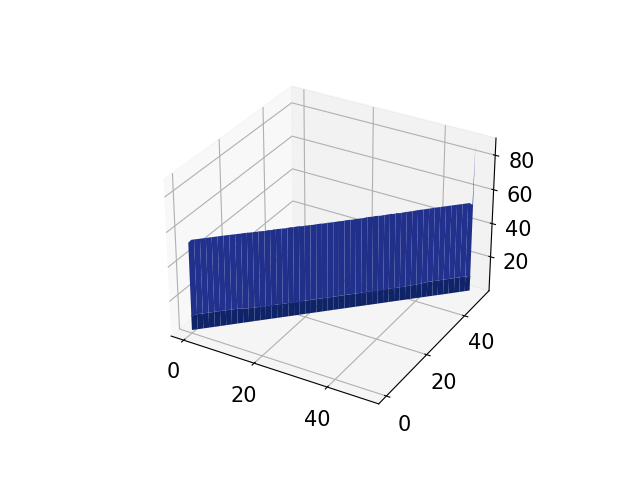

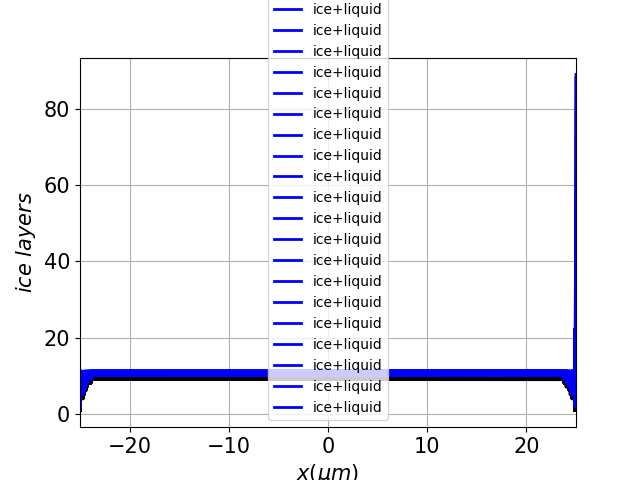

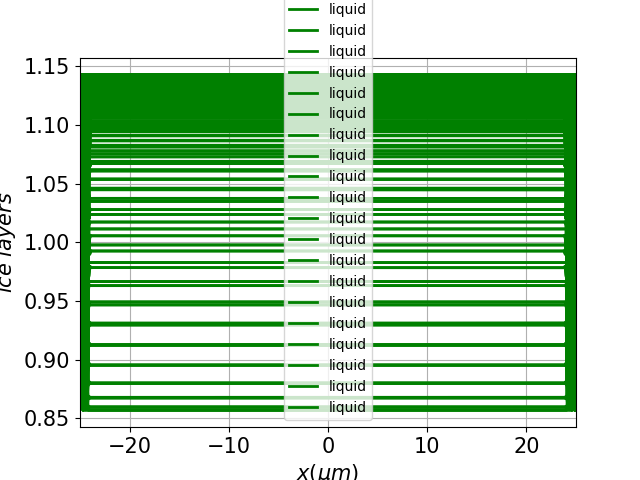

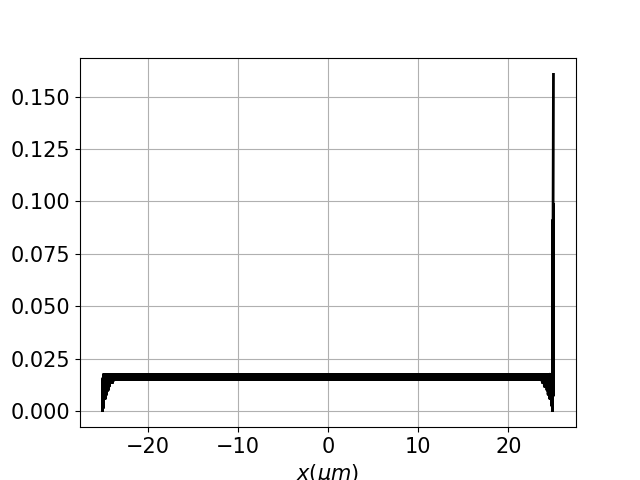

In [14]:
#Plotting the results

# minpoint = min(Nice)
minpoint = 0
ncorner = 4
# print("Height of Ice", minpoint)
delta_Ntot_entire = Ntot-Ntotkeep[0]
# print( "1-D growth, corner", delta_Ntot_entire[ncorner])
# print( "1-D growth, center", delta_Ntot_entire[nmid])
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
# print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
# print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus)
# print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])
alpha = growthrate_entire/nu_kin/sigmastep
# print( "1-D Modeled alpha, corner", alpha[ncorner])
# print( "1-D Modeled alpha, center", alpha[nmid])
# print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)


# Comparisons with 0-D model
# print( "0-D Modeled growth rate, um/s", growthrate_0d)
# print( "0-D Modeled growth rate, ml/us", growthrate_0d/umpersec_over_mlyperus)
# print( "0-D Modeled alpha", alpha_0d)
# print( "Growth ratio 1D (corner)/0D", growthrate_entire[ncorner]/growthrate_0d)
# print( "Growth ratio 1D (center)/0D", growthrate_entire[nmid]/growthrate_0d)
# print( "Contribution of diffusion", (growthrate_entire[nmid]-growthrate_0d)/growthrate_0d*100, '%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
# print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
# print("Libbrecht's predicted alpha", alpha_L)

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

#temp debugging
print("shape of Ntot", np.shape(Ntot))


x = np.linspace(0, xmax, nx)
y = np.linspace(0, ymax, ny)
#Plot the 3d results
fignum +=1
fig = plt.figure(fignum)
ax = fig.add_subplot(111, projection='3d')
#ax.imshow(Nice, aspect='auto', origin='lower', cmap='YlGnBu_r', extent=(0, 2, 0, 2), vmin=0, vmax=200)
#ax.contour(x,y,Nice, extent=(0, 2, 0, 2), cmap='YlGnBu_r', vmin=0, vmax=200, zorder=1)
plot = ax.plot_surface(X=x, Y=y, Z=Nice, cmap='YlGnBu_r', vmin=0, vmax=200)
plt.show()
# Create scale bar
#ax.fill_between(x=[1.4, 1.9], y1=[0.1, 0.1], y2=[0.2, 0.2], color='white')
#ax.text(x=1.65, y=0.25, s='500 nm', va='bottom', ha='center', color='white', size=20)


# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Plot
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

In [15]:
# Saving these results to file
print(Save_new_file,nextfile)
print(trajflag,trajfile)
print(traj0flag,traj0file)
print(Nice[0])
if Nice[0] > 100000:
    Nice -= 100000
    
if Save_new_file:
    print("saving to", nextfile)
    np.savez_compressed(nextfile, Nice=Nice, Fliq=Fliq, 
                        x=x, t=ttot,
                        Nbar=Nbar, Nstar=Nstar,
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)

if trajflag:
    print("saving to", trajfile)
    np.savez_compressed(trajfile, Nice=Nicekeep, Fliq=Fliqkeep,
                        x=x, t=tkeep, 
                        Nbar=Nbar, Nstar=Nstar,
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)
                        
if traj0flag:
    print("saving to", traj0file)
    np.savez_compressed(traj0file, ykeep_0Darr=ykeep_0Darr,
                        x=x, tkeep_0D=tkeep_0D,  
                        sigma0=sigma0, c_r=c_r, D=D, L=L, 
                        nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
                        sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle,
                        dtmaxtimefactor = dtmaxtimefactor,
                        deltaT = deltaT)

False NeshData/continuum_model6 28-5-2016[1][1].npz
False NeshData/continuum_model6 28-5-2016[1][1].traj.npz
False NeshData/continuum_model6 28-5-2016[1][1].traj0.npz
[1.08228376 1.07357705 1.061065   1.08536289 1.07911708 1.06826535
 1.06822023 1.06844509 1.06802961 1.06564945 1.06361373 1.06182572
 1.0602345  1.05987829 1.05947235 1.05906274 1.05871929 1.05926906
 1.05899416 1.05785038 1.05789865 1.05792883 1.05785818 1.05752493
 1.05689956 1.05606348 1.05503304 1.0538196  1.05245429 1.050986
 1.04947424 1.04798063 1.04655381 1.04521565 1.04396094 1.04276901
 1.04161606 1.04048159 1.03935026 1.03821259 1.03706572 1.03591413
 1.03477044 1.03365637 1.03260456 1.03166197 1.03089609 1.03040513
 1.03033241 1.03087767 1.03227508 1.0346666  1.03786889 1.04134926
 1.04458915 1.04734824 1.04961284 1.05146686 1.05301644 1.05436065
 1.05557992 1.05672839 1.05783224 1.05889844 1.05992629 1.06091378
 1.06185909 1.06276023 1.06361443 1.06441817 1.06516761 1.06585928
 1.06649049 1.0670597  1.067566

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()